In [404]:
import sys
import getopt
from enum import Enum
import json
import re
import bisect
import spacy
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Use Spacy NLP
IS_SPACY = True
NLP = spacy.load('en')

In [258]:
# Source of invalid options, whether it is from same passage or random passage
CORPUS_TYPE = Enum('CORPUS_TYPE', 'SAME_PASSAGE RANDOM_PASSAGE')
# Number of invalid options
VARIATION_COUNT = 5
# For corpus type of SAME_PASSAGE, if the passage is smaller then
# variation count, whether to allow duplicates or not
SKIP_SMALL_PASSAGE = False
# Whether we allow duplicate or not in the choices
ALLOW_DUPLICATE_ANSWER = False
# Duplicate for small passage
ALLOW_DUPLICATE_FOR_SMALL = True
# Boolean for printing meta file
IS_META_PRINT = True
# QA separator
QA_SEPARATOR = "*" * 50
# Answer choices
ANSWER_CHOICES = string.uppercase

In [21]:
inputJson = json.load(open('train-v1.0.json'))

In [22]:
inputJson.keys()

[u'version', u'data']

In [24]:
inputJson['version']

u'1.0'

In [35]:
len(trainJson['data'])

442

In [376]:
title = 'Rule_of_law'
subString = 'the functional interpretation of the term'
answerSub = 'little'
qa = {}
paragraph = {}
for document in trainJson['data']:
    if title in document['title']:
        paragraphs = document['paragraphs']
        print "got title"
        break
for paragraph in paragraphs:
    if subString in paragraph['context'].lower():
        context = paragraph['context']
        print "got para"
        break
        
for qa in paragraph['qas']:
    if answerSub in qa['answers'][0]['text'].lower():
        print "got qa"
        break

got title
got para
got qa


In [377]:
qa

{u'answers': [{u'answer_start': 0, u'text': u'little'}],
 u'id': u'5727c7a7ff5b5019007d950f',
 u'question': u'What level of discretion do governments with a high degree of the "rule of law" have?'}

In [368]:
paragraph

{u'context': u"The United States Air Force (USAF) is the aerial warfare service branch of the United States Armed Forces and one of the seven American uniformed services. Initially part of the United States Army, the USAF was formed as a separate branch of the military on 18 September 1947 under the National Security Act of 1947. It is the most recent branch of the U.S. military to be formed, and is the largest and one of the world's most technologically advanced air forces. The USAF articulates its core functions as Nuclear Deterrence Operations, Special Operations, Air Superiority, Global Integrated ISR, Space Superiority, Command and Control, Cyberspace Superiority, Personnel Recovery, Global Precision Attack, Building Partnerships, Rapid Global Mobility and Agile Combat Support.",
 u'qas': [{u'answers': [{u'answer_start': 38,
     u'text': u'the aerial warfare service branch of the United States Armed Forces'}],
   u'id': u'5730bbbb8ab72b1400f9c732',
   u'question': u'What is the U

In [374]:
findSentence(context, 200)

u'initially part of the united states army, the usaf was formed as a separate branch of the military on 18 september 1947 under the national security act of 1947'

In [297]:
paragraph['context']

u'The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study \u2013 aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering \u2013 with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.'

In [298]:
parseBySpacy(paragraph['context'])

u'The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study \u2013. aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering \u2013 with eight B_S_ degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B_A_ and Master of Business Administration (MBA) degrees, respectively.'

In [386]:
pprint.pprint(trainJson['data'][440]['paragraphs'][3]['context'])


u'Hunter-gathering lifestyles remained prevalent in some parts of the New World, Sub-Saharan Africa, and Siberia, as well as all of Australia, until the European Age of Discovery. They still persist in some tribal societies, albeit in rapid decline. Peoples that preserved paleolithic hunting-gathering until the recent past include some indigenous peoples of the Amazonas (Ach\xe9), some Central and Southern African (San people), some peoples of New Guinea (Fayu), the Mlabri of Thailand and Laos, the Vedda people of Sri Lanka, and a handful of uncontacted peoples. In Africa, the only remaining full-time hunter-gatherers are the Hadza of Tanzania.[citation needed]'


In [44]:
trainJson['data'][441]['paragraphs'][0]['context'][615:]

u'tri-city". According to the 2011 census, Kathmandu Metropolitan City has a population of 975,453 and measures 49.45\xa0km2 (19.09\xa0sq\xa0mi).'

In [108]:
def findSentence(context, index):
    sentences = re.split('[.!?]', context)
    accuLengthList = [0]
    for sentence in sentences:
        accuLengthList.append(len(sentence) + accuLengthList[-1] + 1)
    rightSentence = sentences[bisect.bisect(accuLengthList, index) - 1]
    return rightSentence.lower().strip()

In [110]:
findSentence(trainJson['data'][441]['paragraphs'][0]['context'], 725)

u'according to the 2011 census, kathmandu metropolitan city has a population of 975,453 and measures 49'

In [103]:
trainJson['data'][441]['paragraphs'][0]['context'][110:562]

u". It also hosts the headquarters of the South Asian Association for Regional Cooperation (SAARC). It is the only city of Nepal with the administrative status of Mahanagar (Metropolitan City), as compared to Upa-Mahanagar (Sub-Metropolitan City) or Nagar (City). Kathmandu is the core of Nepal's largest urban agglomeration located in the Kathmandu Valley consisting of Lalitpur, Kirtipur, Madhyapur Thimi, Bhaktapur and a number of smaller communities."

In [259]:
def generateSolutions(context, rightSentence):
    answers = []
    sentences = re.split('[.!?]', context)
    sentences = [sentence.strip().lower() for sentence in sentences if len(sentence) > 0]
    isPassageSmall = len(sentences) < VARIATION_COUNT + 1
    if SKIP_SMALL_PASSAGE and isPassageSmall:
        print "Warning, not enough sentences for same passage options"
        return None
    correctChoice = ANSWER_CHOICES[random.randint(0, VARIATION_COUNT)]
    sentences.remove(rightSentence)

    for choice in ANSWER_CHOICES[0:VARIATION_COUNT + 1]:
        if choice == correctChoice:
            answers.extend(["*", choice, ')', rightSentence, '\n'])
        else:
            wrongIdx = random.randint(0, len(sentences) - 1)
            wrongSentence = sentences[wrongIdx]
            answers.extend([choice, ')', wrongSentence, '\n'])
            if ALLOW_DUPLICATE_FOR_SMALL and isPassageSmall:
                continue
            elif not ALLOW_DUPLICATE_ANSWER:
                sentences.remove(wrongSentence)
    return ''.join(answers)

In [227]:
context

u'kathmandu(/\u02cck\u0251\u02d0tm\u0251\u02d0n\u02c8du\u02d0/; nepali pronunciation: [k\u0251\u0288\u02b0m\u0251\u0273\u0256u]) is the capital and largest municipality of nepal. it also hosts the headquarters of the south asian association for regional cooperation (saarc). it is the only city of nepal with the administrative status of mahanagar (metropolitan city), as compared to upa-mahanagar (sub-metropolitan city) or nagar (city). kathmandu is the core of nepal\'s largest urban agglomeration located in the kathmandu valley consisting of lalitpur, kirtipur, madhyapur thimi, bhaktapur and a number of smaller communities. kathmandu is also known informally as "ktm" or the "tri-city". according to the 2011 census, kathmandu metropolitan city has a population of 975,453 and measures 49_45\xa0km2 (19_09\xa0sq\xa0mi).'

In [303]:
def parseBySpacy(context):
    doc = NLP(context, parse=True)
    document = []
    for sent in doc.sents:
        sentence = re.sub('\.', '_', sent.string.strip())
        if sentence[-1] == '_':
            sentence = sentence[:-1] + '.'
        if sentence[-1] != '.':
            sentence += '.'
        document.append(sentence)
    document = ' '.join(document)
    if len(context) != len(document):
        print "Warning, spacy may have parsed the wrong sentences"
        print repr(document)
        print len(document)
        return None
    return document

In [304]:
(parseBySpacy(paragraph['context']))

Warning, spacy may have parsed the wrong sentences
u'The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study \u2013. aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering \u2013 with eight B_S_ degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B_A_ and Master of Business Administration (MBA) degrees, respectively.'
725


In [306]:
(paragraph['context'])

u'The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study \u2013 aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering \u2013 with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.'

In [171]:
originalContext = trainJson['data'][441]['paragraphs'][0]['context']
if IS_SPACY:
    context = parseBySpacy(originalContext)
else:
    context = originalContext
context = context.lower()
rightSentence = findSentence(context, 725)

In [283]:
context

u'kathmandu(/\u02cck\u0251\u02d0tm\u0251\u02d0n\u02c8du\u02d0/; nepali pronunciation: [k\u0251\u0288\u02b0m\u0251\u0273\u0256u]) is the capital and largest municipality of nepal. it also hosts the headquarters of the south asian association for regional cooperation (saarc). it is the only city of nepal with the administrative status of mahanagar (metropolitan city), as compared to upa-mahanagar (sub-metropolitan city) or nagar (city). kathmandu is the core of nepal\'s largest urban agglomeration located in the kathmandu valley consisting of lalitpur, kirtipur, madhyapur thimi, bhaktapur and a number of smaller communities. kathmandu is also known informally as "ktm" or the "tri-city". according to the 2011 census, kathmandu metropolitan city has a population of 975,453 and measures 49_45\xa0km2 (19_09\xa0sq\xa0mi).'

In [174]:
rightSentence

u'according to the 2011 census, kathmandu metropolitan city has a population of 975,453 and measures 49_45\xa0km2 (19_09\xa0sq\xa0mi)'

In [387]:
import json

In [417]:
data = json.load(open('packet_variation.json', 'r'))

In [427]:
zip(zip(zip(variationCount, pps), batchSize), [id['id'] for id in data['jobs']])

[(((4, u'3018.0'), 5), u'1467077528559'),
 (((4, u'4137.0'), 10), u'1467077529356'),
 (((4, u'4547.0'), 15), u'1467077530278'),
 (((4, u'4537.0'), 20), u'1467077531075'),
 (((4, u'4537.0'), 25), u'1467077531887'),
 (((4, u'5050.0'), 30), u'1467077532684'),
 (((9, u'2666.0'), 5), u'1467077533513'),
 (((9, u'3027.0'), 10), u'1467077534325'),
 (((9, u'3248.0'), 15), u'1467077535185'),
 (((9, u'3258.0'), 20), u'1467077535997'),
 (((9, u'3021.0'), 25), u'1467077536794'),
 (((9, u'3020.0'), 30), u'1467077537591'),
 (((14, u'2170.0'), 5), u'1467077538451'),
 (((14, u'2164.0'), 10), u'1467077539263'),
 (((14, u'2393.0'), 15), u'1467077540122'),
 (((14, u'2269.0'), 20), u'1467077540919'),
 (((14, u'2388.0'), 25), u'1467077541716'),
 (((14, u'2388.0'), 30), u'1467077542513'),
 (((19, u'1817.0'), 5), u'1467077543310'),
 (((19, u'1818.0'), 10), u'1467077544138'),
 (((19, u'1813.0'), 15), u'1467077544920'),
 (((19, u'1816.0'), 20), u'1467077545748'),
 (((19, u'1890.0'), 25), u'1467077546529'),
 (((

In [418]:
pps = [x['pps'] for x in data['jobs']]
variationCount = [x['config']['variationCount'] for x in data['jobs']]
batchSize = [x['config']['batchSize'] for x in data['jobs']]

In [423]:
zip(zip(variationCount, pps), batchSize)

[((4, u'3018.0'), 5),
 ((4, u'4137.0'), 10),
 ((4, u'4547.0'), 15),
 ((4, u'4537.0'), 20),
 ((4, u'4537.0'), 25),
 ((4, u'5050.0'), 30),
 ((9, u'2666.0'), 5),
 ((9, u'3027.0'), 10),
 ((9, u'3248.0'), 15),
 ((9, u'3258.0'), 20),
 ((9, u'3021.0'), 25),
 ((9, u'3020.0'), 30),
 ((14, u'2170.0'), 5),
 ((14, u'2164.0'), 10),
 ((14, u'2393.0'), 15),
 ((14, u'2269.0'), 20),
 ((14, u'2388.0'), 25),
 ((14, u'2388.0'), 30),
 ((19, u'1817.0'), 5),
 ((19, u'1818.0'), 10),
 ((19, u'1813.0'), 15),
 ((19, u'1816.0'), 20),
 ((19, u'1890.0'), 25),
 ((19, u'1974.0'), 30),
 ((24, u'1512.0'), 5),
 ((24, u'1509.0'), 10),
 ((24, u'1565.0'), 15),
 ((24, u'1563.0'), 20),
 ((24, u'1563.0'), 25),
 ((24, u'1562.0'), 30),
 ((29, u'1259.0'), 5),
 ((29, u'1297.0'), 10),
 ((29, u'1194.0'), 15),
 ((29, u'1334.0'), 20),
 ((29, u'1334.0'), 25),
 ((29, u'1375.0'), 30)]

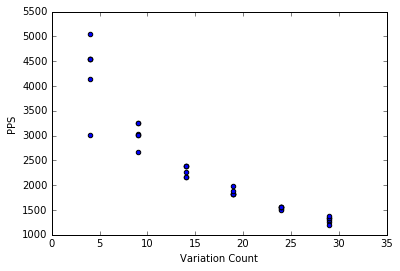

In [421]:
plt.scatter(variationCount, pps)
plt.xlabel('Variation Count')
plt.ylabel('PPS')

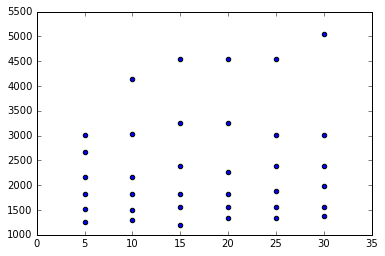

In [420]:
plt.scatter(batchSize, pps)